# Import Libraries

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# magic word for producing visualizations in notebook
%matplotlib inline

# Data Visualization

In [2]:
azdias = pd.read_csv('../capstone_data/Udacity_AZDIAS_052018.csv')
# customers = pd.read_csv('../capstone_data/Udacity_CUSTOMERS_052018.csv')

/home/cmu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# mailout_train=pd.read_csv('../capstone_data/Udacity_MAILOUT_052018_TRAIN.csv')
# mailout_test=pd.read_csv('../capstone_data/Udacity_MAILOUT_052018_TEST.csv')

# Data Preprcocessing

In [3]:
def Attribute_Unknown_Dict(path,df):
    '''
    Purpose: Map all the attributes to their unknown values in a dictionary
    
    Input: PATH TO DIAS Attributes - Values 2017.xlsx file, in str format
    
    Output:
    new_dict:Dictionary with attributes as key and the unknown meaning values in a list
    '''
    #reading the xlsx file and storing it in a dataframe
    attributes=pd.read_excel(path,skiprows=1)
    
    #formatting
    attributes=attributes.drop(['Unnamed: 0'],axis=1,inplace=False)
    
    #Droping all the rows with nan values. Since, all the first values refer to the unknown meaning category\
    #Only keeping the first row for each attribute works
    attributes=attributes.dropna()
    
    new_dict={}
    for i in range(attributes.shape[0]):
        #checking if it corresponds to the unknown value
        if ('unknown' in attributes['Meaning'].iloc[i].split()) or(attributes['Meaning'].iloc[i] == 'no transaction known'):
            new_list=[]
            if type(attributes['Value'].iloc[i])==int:
                new_list.append(attributes['Value'].iloc[i])
            else:
                for j in attributes['Value'].iloc[i].split(','):
                    new_list.append(int(j))

            new_dict[attributes['Attribute'].iloc[i]]=new_list
    
    #These columns are not present in  the actual dataset
    new_dict.pop('BIP_FLAG')
    new_dict.pop('GEOSCORE_KLS7')
    new_dict.pop('HAUSHALTSSTRUKTUR')
    new_dict.pop('SOHO_FLAG')
    new_dict.pop('WACHSTUMSGEBIET_NB')
    
    
    #Removing name '_RZ' from the end of each column name
    for i in new_dict:
        if i not in df.columns:
            new_dict[i[:-3]]=new_dict.pop(i)
    
    #removing the last key_value pair
    new_dict.pop('')
    
    
    return new_dict

Mapping the unknown values to nan with the help of the attribute_dict

In [32]:
#replacing unknown values with nan
def Map_unknown_to_NAN(df,attribute_dict):
    '''
    Replace the unknown values with NAN values in the df
    ARGS:
    df: Dataframe on which the mapping takes place like azdias
    attribute_dict: Dict with attribute as keys and values which are to replaced with NAN
    
    Output:
    df: transformed df with more null values
    
    '''
    #Replacing 
    for key,val in attribute_dict.items():
        for j in val:
            df[key]=df[key].replace(j,np.nan)
            
    #listing the columns which have more than 50% null values
    drop_col_list=list(df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0.50*(df.shape[0])]\
                   .reset_index()['index'])
    df.drop(drop_col_list,axis=1,inplace=True)
    
#     #listing the index of the rows which have more than 20% nan values and droping them
#     drop_row_list=list(azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1)>(0.2*azdias.shape[1])].reset_index()['index'])
#     df=df.drop(index=drop_row_list)
    
                
    return df

We need to replace these values with NAN value and convert CAMEO_INTL_2015 and CAMEO_DEUG_2015 into numerical entries

In [5]:
def cat_to_num(df):
    '''
    converting columns which are categorical to numerical and droping other categorical columns
    INput: 
    df: DataFrame to be processed
    
    Output:
    df: After droping and converting categorical columns
    
    '''
    
    #converting CAMEO_INTL_2015 AND CAMEO_DEUB_2015 into numerical values
    intl=[]
    deug=[]
    for i in range(len(df['CAMEO_INTL_2015'])):
        if type(df['CAMEO_INTL_2015'].iloc[i])==str and df['CAMEO_INTL_2015'].iloc[i][0]=='X':
            intl.append(np.nan)
        else:
            intl.append(float(df['CAMEO_INTL_2015'].iloc[i]))
        if type(df['CAMEO_INTL_2015'].iloc[i])==str and df['CAMEO_DEUG_2015'].iloc[i][0]=='X':
            deug.append(np.nan)
        else:
            deug.append(float(df['CAMEO_DEUG_2015'].iloc[i]))
    
    #droping the original columns
    df=df.drop(['CAMEO_INTL_2015','CAMEO_DEUG_2015'],axis=1,inplace=False)
    #Adding new columns
    df['CAMEO_INTL_2015']=intl
    df['CAMEO_DEUG_2015']=deug
    
    #droping 'LNR' AND 'VERDICHTUNGSRAUM' columns
    #droping the 'LP_FAMILIE_GROB' column because it very similar 'LP_FAMILIE_FEIN'

    df=df.drop(['LNR','VERDICHTUNGSRAUM','LP_FAMILIE_GROB'],axis=1,inplace=False)
    
    return df
    

Mixed Categories can be segregated into individual categories. For example, 'CAMEO_INTL_2015' can be split into 'WEALTH' and 'LIFE_CYCLE'. Similarly, we can split 'PRAEGENDE_JUGENDJAHRE' into 'MOVEMENT' AND 'GENERATION'

In [6]:
def mixed_categories(df):
    '''
    Spliting mixed attributes into individua;
    Input:
    df: DataFrame to be processed
    
    Output:
    df
    '''
    
    df['WEALTH']=df['CAMEO_INTL_2015'].apply(lambda x:x/10)
    df['LIFE_CYCLE']=df['CAMEO_INTL_2015'].apply(lambda x:x%10)
    
    mainstream=[1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
    avantgarde=[2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]
    
    main=df['PRAEGENDE_JUGENDJAHRE'].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    avar=df['PRAEGENDE_JUGENDJAHRE'].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])
    
    df.loc[main,'MOVEMENT']=1.0
    df.loc[avar,'MOVEMENT']=2.0
    
    df=df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'],axis=1,inplace=False)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    new_df=pd.get_dummies(df,columns=['CAMEO_DEU_2015'])
    
    new_df=new_df.drop(['CAMEO_DEU_2015_XX'],axis=1,inplace=False)
    
    return new_df
    
    

In [7]:
def impute_and_standardize(df):
    '''
    Replacing all the null values with mean of the column
    
    '''
    
    fill_mean=lambda col:col.fillna(col.mean())
    df=df.apply(fill_mean,axis=0)
    
    scaler=StandardScaler()
    
    df=scaler.fit_transform(df)
    
    return df

In [8]:
def clean_data(df):
    '''
    Function which integrates all the above functions and returns clean dataFrame
    Input: data to be cleaned in dataFrame 
    
    Output: clean data Frame
    '''
    
    #Map all the attributes to their unknown values in a dictionary
    attribute_dict=Attribute_Unknown_Dict('../capstone_data/DIAS Attributes - Values 2017.xlsx',df)
    
    df=Map_unknown_to_NAN(df,attribute_dict)
    
    df=cat_to_num(df)
    
    df=mixed_categories(df)
    df_col=df.columns
    df=impute_and_standardize(df)
    
    
    
    return df,df_col
                                          

In [9]:
clean_azdias,azdias_col=clean_data(azdias)

In [10]:
del azdias

# PCA 

In [13]:
n_components=int((clean_azdias.shape[1])/1.8)

pca = PCA(n_components)
df_pca = pca.fit_transform(clean_azdias)

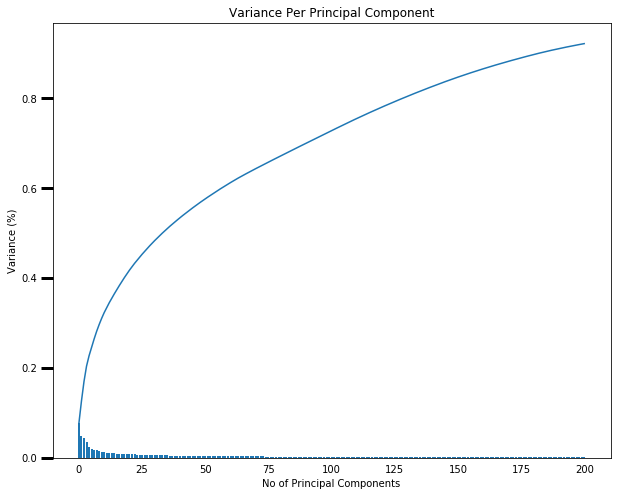

In [14]:
index=np.arange(n_components)
value=pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
ax = plt.subplot()
cum_value = np.cumsum(value)
ax.bar(index, value)
ax.plot(index, cum_value)
for i in range(n_components):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=3, length=12)

    ax.set_xlabel("No of Principal Components")
    ax.set_ylabel("Variance (%)")
    plt.title('Variance Per Principal Component')

In [15]:
sum(pca.explained_variance_ratio_)

0.921964550914719

In [16]:
n_components

201

In [17]:
#Converting the PCA components to the features of the clean dataset. 
#Mapping each feature to the principal components

dim =['Dimension' +str(i) for i in range(1,len(pca.components_)+1)]
comp_dist=pd.DataFrame(np.round(pca.components_,5),columns=azdias_col)
comp_dist.index=dim

In [18]:
comp_dist.head(3)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
Dimension1,-0.06112,0.01342,-0.01087,-0.07998,-0.01833,0.02989,0.07080,-0.07839,0.00264,-0.09403,...,-0.00316,-0.04535,-0.02799,-0.02383,-0.02191,-0.02338,-0.04239,-0.04343,-0.04309,-0.01330
Dimension2,0.01569,-0.02238,-0.01886,0.02030,0.02717,-0.01505,-0.02432,0.01958,0.01148,-0.03619,...,-0.00530,-0.00835,0.02904,-0.02554,-0.01858,-0.01086,-0.01850,0.00291,-0.00090,0.00889
Dimension3,-0.00828,0.15035,0.14288,0.00695,-0.00352,0.07783,0.07874,0.00288,-0.00247,0.00473,...,-0.00796,0.01176,0.01564,-0.00221,-0.01782,0.01571,0.01438,0.01673,0.01244,-0.02166


In [19]:
comp_dist.iloc[0].sort_values(ascending=False)

MOBI_REGIO      0.14437
PLZ8_ANTG1      0.14269
KBA13_ANTG1     0.14213
KBA05_ANTG1     0.13422
MOBI_RASTER     0.13274
                 ...   
PLZ8_ANTG4     -0.13624
KBA13_BAUMAX   -0.13700
KBA13_ANTG4    -0.13775
KBA13_ANTG3    -0.14113
PLZ8_ANTG3     -0.14163
Name: Dimension1, Length: 363, dtype: float64

In [20]:
comp_dist.iloc[1].sort_values(ascending=False)

KBA13_HERST_BMW_BENZ           0.18315
KBA13_MERCEDES                 0.15690
KBA13_SEG_OBEREMITTELKLASSE    0.15629
KBA13_BMW                      0.15229
KBA13_SITZE_4                  0.14574
                                ...   
KBA13_KMH_180                 -0.12094
KBA13_HALTER_25               -0.12098
KBA13_SEG_KLEINWAGEN          -0.13142
KBA13_KMH_140_210             -0.13198
KBA13_SITZE_5                 -0.15013
Name: Dimension2, Length: 363, dtype: float64

In [21]:
comp_dist.iloc[3].sort_values(ascending=False)

FINANZ_VORSORGER         0.13537
ALTERSKATEGORIE_GROB     0.13130
D19_GESAMT_ANZ_24        0.12884
D19_GESAMT_ANZ_12        0.12424
D19_VERSAND_ANZ_24       0.11978
                          ...   
CJT_TYP_2               -0.14797
CJT_TYP_1               -0.15497
FINANZ_UNAUFFAELLIGER   -0.15600
FINANZ_ANLEGER          -0.15780
FINANZ_SPARER           -0.16038
Name: Dimension4, Length: 363, dtype: float64

In [25]:
df_pca.shape

(891221, 201)

# Clustering Azdias_df

In [22]:
score=[]
centers=np.arange(10,31)

for i in centers:
    
    k_mean=MiniBatchKMeans(n_clusters=i).fit(df_pca)
    #Append the score with different centers
    score.append(np.abs(k_mean.score(df_pca)))

Text(0.5, 1.0, 'Sum of Squared distance for different no of centers')

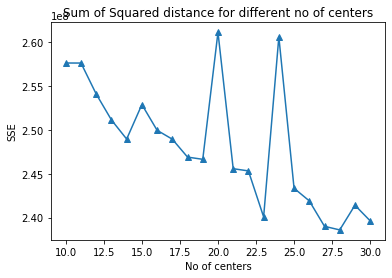

In [23]:
plt.plot(centers,score,marker='^')
plt.xlabel('No of centers')
plt.ylabel('SSE')
plt.title('Sum of Squared distance for different no of centers')

In [26]:
kmeans=KMeans(n_clusters=30)
df_kmeans=kmeans.fit_predict(df_pca)

In [ ]:
t=np.round(pca.components_,5).reshape(-1,len(dim))

In [ ]:
t.shape

In [ ]:
df_kmeans.shape

In [28]:
df_cluster=pd.DataFrame(np.round(df_pca,5),columns=dim)
df_cluster.insert(loc=0,column='Cluster',value=df_kmeans)
df_cluster.head()

,Cluster,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,...,Dimension192,Dimension193,Dimension194,Dimension195,Dimension196,Dimension197,Dimension198,Dimension199,Dimension200,Dimension201
0,28,-1.04178,0.58871,-3.15077,-1.11485,0.17407,-0.24985,-0.42848,0.27544,-0.50469,...,0.10586,0.11510,0.71211,0.14001,-0.45764,-0.27565,-0.39455,-0.29919,0.03516,0.58971
1,10,-4.15687,5.35438,4.01153,-5.78297,0.48602,3.35849,-3.79806,0.55148,0.25724,...,-0.37591,0.14128,0.17835,0.31736,0.33517,0.52263,0.02368,0.66786,1.08540,-0.21511
2,10,0.83112,3.05910,-1.28712,-3.05368,4.92575,-6.23849,-0.40429,-2.37726,1.68692,...,0.34279,0.27036,-0.40964,-0.39461,0.45014,-0.88653,-1.20327,0.92056,-0.00339,-0.57601
3,25,5.34641,1.33627,-5.04786,-2.72614,-0.95218,1.15366,-1.43716,-1.43916,-2.63117,...,1.45164,0.54156,0.27683,1.04439,0.02290,1.35529,-0.39524,-0.36100,0.08803,-0.36264
4,14,4.00906,0.64782,10.07008,8.03038,-3.88573,-0.75030,3.37293,-3.33334,-0.21971,...,1.28007,0.99303,-0.68809,-0.23480,0.17220,-0.67771,-0.31977,-1.64303,1.01603,-0.67538


# Applying these changes to the customer_dataset

In [40]:
customers = pd.read_csv('../capstone_data/Udacity_CUSTOMERS_052018.csv')

/home/cmu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
customers=customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [44]:
def clean_data_cust(df):
    '''
    Function which integrates all the above functions and returns clean dataFrame
    Input: data to be cleaned in dataFrame 
    
    Output: clean data Frame
    '''
    
    #Map all the attributes to their unknown values in a dictionary
    attribute_dict=Attribute_Unknown_Dict('../capstone_data/DIAS Attributes - Values 2017.xlsx',df)
    
    df=Map_unknown_to_NAN(df,attribute_dict)
    
    df=cat_to_num(df)
    
    df=mixed_categories(df)
    df_col=df.columns    
    
    return df,df_col

In [45]:
clean_customer,cust_col=clean_data_cust(customers)

In [46]:
clean_customer.shape

(191652, 366)

In [47]:
missing = list(np.setdiff1d(cust_col, azdias_col))

In [50]:
clean_customer=clean_customer.drop(columns=missing,axis=1,inplace=False)

In [51]:
clean_cust=impute_and_standardize(clean_customer)

In [52]:
cust_pca=pca.transform(clean_cust)
cust_kmeans=kmeans.predict(cust_pca)

In [57]:
cust_df=pd.DataFrame(np.round(cust_pca,5),columns=dim)
cust_df.insert(loc=0,column='Cluster',value=cust_kmeans)
cust_df.head()

,Cluster,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,...,Dimension192,Dimension193,Dimension194,Dimension195,Dimension196,Dimension197,Dimension198,Dimension199,Dimension200,Dimension201
0,6,6.56040,3.30415,-4.56372,-1.54779,-1.81912,1.05470,2.78129,-0.50937,0.86883,...,0.82705,-1.15704,-0.21712,1.01611,-0.02516,0.34859,0.24546,-1.01242,-0.48045,1.46878
1,1,-0.49822,0.19756,-1.80821,-0.77362,-0.13141,0.95430,1.87865,-0.06061,0.55367,...,0.23321,0.62334,-1.86039,-0.69803,0.47049,-0.36734,1.02822,0.12224,-0.09903,0.73809
2,27,-5.47496,3.39029,-5.03725,2.16477,-4.44320,-1.57986,-0.92274,3.18116,-7.08568,...,0.60274,-0.41072,-2.00342,0.08217,-0.33453,0.14120,0.16044,-1.36128,0.03925,-0.27896
3,13,3.24840,-3.25359,-4.22626,-0.49862,4.04975,2.96504,1.97542,-5.44039,-0.33511,...,-0.30213,-1.35705,-0.02951,-0.59241,0.73874,-0.90232,-0.89211,0.14441,1.30047,-0.95653
4,0,-4.02268,-4.83188,8.96208,1.94190,-5.56753,-0.79677,0.12042,-0.46087,3.21080,...,0.36106,-0.01591,-1.00247,-1.19885,0.53258,-0.45583,0.54706,0.63656,-0.31067,-0.20078


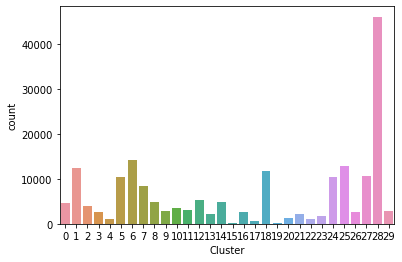

In [58]:
sns.countplot(cust_df['Cluster'])

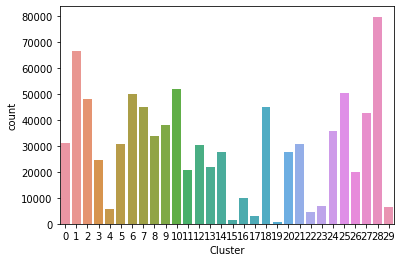

In [59]:
sns.countplot(df_cluster['Cluster'])

In [155]:
#Creating a df from the difference of both the clusters
azdias_count=(df_cluster['Cluster'].value_counts()/df_cluster.shape[0])
cust_count=(cust_df['Cluster'].value_counts()/cust_df.shape[0])

diff_count=cust_count-azdias_count

In [159]:
diff_count=diff_count.sort_values(ascending=False)

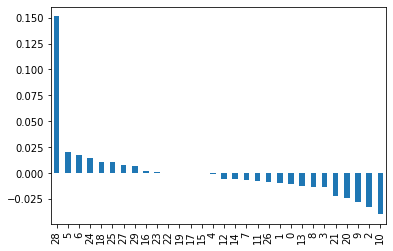

In [160]:
diff_count.plot.bar()

In [161]:
def map_cluster_to_columns(cluster_num):
    '''
    Function to infer the columns which are similar or which are dissimilar
    Input:
    cluster_num: Cluster_number
    '''
    temp=cust_df[cust_df['Cluster']==cluster_num]
    temp=temp.drop(['Cluster'],axis=1,inplace=False)
    
    cluster_pca=pca.inverse_transform(temp)
    
    cluster_final=pd.DataFrame(cluster_pca,columns=clean_customer.columns)
    
    return cluster_final
    

In [163]:
target=map_cluster_to_columns(28)
target.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,0.051736,0.160286,0.092746,0.001933,-0.006894,-0.029662,-0.155710,0.005322,-0.004706,0.010760,...,-0.063980,-0.164579,-0.152364,-0.115888,-0.093787,-0.082504,-0.082368,-0.084925,-0.126452,-0.071388
1,0.045991,0.177824,0.045225,0.005220,-0.000703,-0.022693,-0.152972,0.007487,0.000606,-0.005445,...,-0.064699,-0.156529,-0.135491,-0.118424,-0.102111,-0.083540,-0.082617,-0.079449,-0.135161,-0.076862
2,0.048872,0.169055,0.068989,0.003576,-0.003801,-0.026176,-0.154340,0.006404,-0.002048,0.002653,...,-0.064340,-0.160555,-0.143928,-0.117157,-0.097946,-0.083019,-0.082496,-0.082185,-0.130803,-0.074127
3,0.045124,0.154292,0.116327,0.009433,-0.010316,-0.013691,-0.174826,0.011345,0.000723,0.020049,...,-0.068261,-0.180518,-0.166156,-0.111775,-0.101992,-0.079535,-0.083792,-0.104459,-0.130693,-0.085606
4,0.039382,0.171829,0.068805,0.012721,-0.004127,-0.006725,-0.172086,0.013512,0.006033,0.003844,...,-0.068994,-0.172461,-0.149285,-0.114309,-0.110323,-0.080566,-0.084044,-0.098978,-0.139410,-0.091086


In [167]:
infer_columns=['MOBI_REGIO',
               'PLZ8_ANTG1',
               'KBA13_HERST_BMW_BENZ',
               'KBA13_MERCEDES',
               'FINANZ_VORSORGER',
               'ALTERSKATEGORIE_GROB']

In [176]:
target.describe().loc['mean'].sort_values(ascending=False)

KOMBIALTER               1.879128
FINANZ_ANLEGER           1.687641
FINANZ_UNAUFFAELLIGER    1.686002
SEMIO_REL                1.522650
FINANZ_SPARER            1.362063
                           ...   
FINANZ_VORSORGER        -0.974725
LP_LEBENSPHASE_GROB     -1.003114
LP_LEBENSPHASE_FEIN     -1.050301
GEBURTSJAHR             -1.098353
SEMIO_VERT              -1.470410
Name: mean, Length: 363, dtype: float64

In [165]:
non_target=map_cluster_to_columns(10)
non_target.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.700466,0.254547,0.529812,-0.338245,-0.077442,-0.261260,-1.663825,-0.335567,-0.181222,-0.423971,...,-0.035791,-0.228227,-0.180899,-0.008583,-0.107680,-0.021045,-0.046484,-0.141458,-0.257203,-0.145969
1,-0.831263,-0.420296,-1.818865,-0.403254,0.010507,-0.650545,0.301046,-0.384662,-0.193979,-0.402436,...,-0.081358,-0.160315,-0.087698,-0.180225,-0.072180,-0.089558,-0.086017,-0.081940,-0.138003,-0.109781
2,-0.482692,1.013010,0.899632,-0.122817,-0.025345,-0.481288,-1.600093,-0.133174,-0.203369,0.442939,...,-0.056321,-0.110801,-0.028255,-0.057276,-0.140608,-0.001900,0.051006,-0.045191,-0.084765,-0.060253
3,-0.048877,0.671538,0.742284,-0.098130,-0.166816,-0.457904,-1.131420,-0.151388,-0.119497,-0.284424,...,-0.049000,-0.032095,-0.089223,0.028633,-0.003579,0.024812,-0.079230,-0.065878,-0.065009,-0.054319
4,2.910669,0.999604,1.456773,0.421635,-0.180153,-0.349042,-1.049000,0.436674,-0.146203,-0.702576,...,-0.087799,-0.109823,-0.172610,-0.161674,-0.144314,-0.071517,-0.062655,-0.027192,-0.086322,-0.138627


In [177]:
non_target.describe().loc['mean'].sort_values(ascending=False)

VK_ZG11                 0.962363
RT_UEBERGROESSE         0.954917
CJT_TYP_1               0.930878
CJT_TYP_2               0.850704
EINGEZOGENAM_HH_JAHR    0.811286
                          ...   
CJT_KATALOGNUTZER      -0.979082
CJT_TYP_6              -1.342059
CJT_TYP_5              -1.488315
CJT_TYP_4              -1.575580
CJT_TYP_3              -1.612491
Name: mean, Length: 363, dtype: float64

In [173]:
target_mean=target.describe()[infer_columns].loc['mean']
non_target_mean=non_target.describe()[infer_columns].loc['mean']

In [174]:
mean_df = pd.concat([target_mean, non_target_mean], axis=1)
mean_df.columns = ['Target', 'Non-Target']

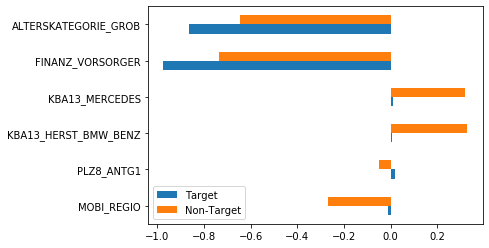

In [175]:
mean_df.plot.barh()